<a href="https://colab.research.google.com/github/joaosds/Ising2DNumba/blob/main/Ising2dNumba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Numba Implementation of the Ising 2D with Metropolis Monte Carlo


---


Abstract: We perform an implementation of the Metropolis Algorithm with the Ising 2D system using the programming language Python and the parallelization package Numba. Physical observables such as the Magnetization, Specific Heat and susceptibility are calculated and compared with the classical phase diagram separating the disordered (paramagnetic) to the ordered state (ferromagnetic).

Authors: João Augusto S. S. and Vitor D. Meireles

Last modification: 13/04/21

---



## Monte Carlo and the Metropolis Algorithm

### Thermalization, Expectation values and General Remarks

 The basic idea behind the Monte Carlo technique is to simulate random thermal fluctuations on a specific system from one to state to another over the course of an *experiment*. In this realization, a random sampling is constructed after the *thermalization* of the system for the correct calculation of the physical observables. This thermalization occurs when all our probabilities tend to the equilibrium occupation probabilities of thermodynamics, in general, being represented in the limit $t\rightarrow\infty$.
 
To understand how we may calculate them, we begin by reminding the time evolution of a system constitued by a probabilistic combination of states. This is given by the *master equation* $$\frac{d\omega_{\mu}}{dt}=\sum_{\nu}\left[\omega_{\nu}\left(t\right)R\left(\nu\rightarrow\mu\right)-\left(t\right)R\left(\nu\rightarrow\mu\right)-\right]$$
 
  After the thermalization of the system, we can calculate a mean over physical observables, the so-called *estimators*. For a quantity $Q$ on a state $\mu$, $$\left<Q\right>=\sum_{\mu}Q_{\mu}P$$

### The Ising 

### Energetics of Ising Hamiltonian

From the Ising Hamiltonian, the energy difference $$E_{\nu}-E_{\mu}=-J\sum_{\left<i,j\right>}S_{i}^{\nu}S_{i}^{\nu}+J\sum_{\left<i,j\right>}S_{i}^{\mu}S_{i}^{\mu}=-J\sum_{\left<i,j\right>}S_{i}^{\mu}\left(S_{j}^{\nu}-S_{j}^{\mu}\right)$$
can be rewritten as $$\Delta E^{k}_\left({\nu-\mu}\right) = 2J\sum_{\left<k,j\right>}S_{k}^{\mu}S_{j}^{\nu}= 2JS_{k}^{\mu}\sum_{\text{j n.n. to k}}S_{j}^{\nu}.$$
### Magnetization $M\left(T\right)$

### Specific Heat $C\left(T\right)$
## Pseudo-Code

1.   Initial Configuration: define array $H\left(N\right)$ with $N$ random values $s=\pm 1$ and $\dim\left(N\right)$; -OK


2.   Next neighbors table: identify next nearest neighbors and construct an n.n.'s table;

3.   Boundary conditions: impose periodic boundaries (system translationally invariant);
4.   Initial conditions: Fix $\beta\left(T\right)$ and initial conditions;
5.   Set of simulations from $T_{i}$ to $T_{f}$: the last state of $T_{j}$ on the $j\text{th}$ run is always the initial one of the following $\left(j+1\right)\text{th}$;
6.   Generation of state: randomly flip skin on $k\text{th}$ position.
7.   Metropolis rule: 
*   If $\Delta E_{\nu-\mu}^{k} \leq0 \Rightarrow  S_{k} \rightarrow -S_{k}; $
*   If $\Delta E_{\nu-\mu}^{k} \gt 0:$
    *   Calculate $\mathcal{A}\left(\mu\rightarrow\nu\right)=e^{-\beta\left(E_{\nu}-E_{\mu}\right)}$. Generate a random $r \in \left[0,1\right]$. If $r\lt\mathcal{A}\left(\mu\rightarrow\nu\right)\Rightarrow$ Flip the spin. If not, leave it.

















---

Let's begin by importing the necessary packages for our task.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from numba import njit
import time

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Helvetica']})
rc('text', usetex=True)

Following the Pseudo-Code, we need to build the initial lattice with randomly determined spins and check them graphically.

[[-1 -1  1 ...  1 -1 -1]
 [ 1 -1 -1 ... -1  1 -1]
 [-1  1  1 ... -1  1 -1]
 ...
 [-1 -1 -1 ... -1 -1  1]
 [ 1 -1  1 ...  1  1  1]
 [-1  1 -1 ...  1  1  1]]
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


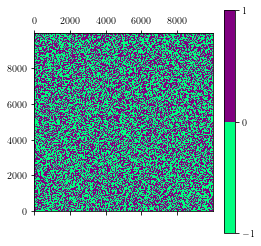

In [ ]:
def initial_lattice(n):
    return np.random.choice([1, -1], size=(n, n))

n = 10000
nz = 4
lattice = initial_lattice(n)

# make a color map of fixed colors
cmap = colors.ListedColormap(['springgreen', 'purple'])
bounds=[-1,0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = plt.matshow(lattice, interpolation='nearest', origin='lower',
                    cmap=cmap,norm=norm)

# make a color bar
plt.colorbar(img, boundaries=bounds, ticks=[-1, 0, 1])

print(lattice)
%time

The next step is building the proper lattice with the correspondent boundary conditions. We do this following a general approach extensible to any geometrical configuration.  Each site will have a number associated given by the function *lsite*. 

In [ ]:
@njit
def lsite(x,y):
    return x+y*n

# Nearest Neighbors definition: Square lattice.
@njit
def square_ngb(ix,iy):

    nsite = np.zeros((nz,2))
    
#right:
    ix0 = ix+1
    iy0 = iy
    if ix0 > n-1:
        ix0 = ix0 - n
    nsite[0,0] = ix0
    nsite[0,1] = iy0
    
#left:
    ix0 = ix-1
    iy0 = iy
    if ix0 < 0:
        ix0 = ix0 + n
    nsite[1,0] = ix0
    nsite[1,1] = iy0
#up:
    ix0 = ix
    iy0 = iy+1
    if iy0 > n-1:
        iy0 = iy0 - n
    nsite[2,0] = ix0
    nsite[2,1] = iy0
#down:
    ix0 = ix
    iy0 = iy-1
    if iy0 < 0:
        iy0 = iy0 + n
    nsite[3,0] = ix0
    nsite[3,1] = iy0

    return nsite

# Square lattice construction:

@njit
def neighbors():
    ngb = np.zeros((n**2,nz))
    
    for ix in range(n):
        for iy in range(n):
            
            st = lsite(ix,iy)
            
            site = square_ngb(ix,iy)
            
            for m in range(nz):
                ngb[st,m] = lsite(site[m,0],site[m,1])
    
    return ngb

neighbors = neighbors()
# %time

penis


For the main part of the MC algorithm we now turn our attention to calculate the probabilities and  

# Future Improvements and To-Do List



*  Chapter 4 of Barkema: Study of the Wolf Algorithm and other extensions for the Ising example;



# References